In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from gurobipy import Model, GRB, quicksum
from Services.read_data import Dados
import math
import pandas as pd
from Services import matriz_precedencia as mp

In [37]:
# Inicialização da classe Dados
file_name = 'Dados\Modelo.xlsx'
dados = Dados(file_name)

In [38]:
# ROTA: MAO => PEC => SUA => SSZ => PNG => PNG => SSZ => SUA => PEC => MAO
NB = [1, 2, 3, 4, 5]
SB = [5, 4, 3, 2, 1]

# Obtém a matriz de precedência a partir da rota
dados.M = mp.gerar_matriz_precedencia(NB, SB)

# Ordem dos portos
ordem = NB + SB

# Indexação dos portos
ordem = pd.DataFrame(ordem, index=[i + 1 for i in range(len(ordem))], columns=['IdPorto'])

In [39]:
port_nums = ordem['IdPorto'].drop_duplicates().values
port_nums.sort()

In [40]:
port_nums

array([1, 2, 3, 4, 5], dtype=int64)

In [41]:
# Criar o modelo
model = Model("Modelo de Otimização de Cabotagem")

In [42]:
CT = model.addVar(vtype=GRB.CONTINUOUS, name="CT", lb=0, ub=1)  # Margem de contribuição
FF = model.addVars(dados.P, dados.P, dados.K, dados.C, dados.T, vtype=GRB.CONTINUOUS, name="FF")  # Contêineres cheios embarcados
FE = model.addVars(dados.P, dados.P, dados.K, dados.T, vtype=GRB.CONTINUOUS, name="FE")    # Contêineres vazios embarcados
CREMAS = model.addVars(dados.P, dados.K, dados.T, vtype=GRB.CONTINUOUS, name="E")         # Estoque de contêineres vazios
R = model.addVars(dados.P, dados.T, vtype=GRB.CONTINUOUS, name="R")            # Quantidade de TEU no navio
RSF = model.addVars(dados.P, dados.K, dados.T, vtype=GRB.CONTINUOUS, name="RSF")     # Contêineres vazios retornando
RSE = model.addVars(dados.P, dados.K, dados.T, vtype=GRB.CONTINUOUS, name="RSE")     # Contêineres vazios disponíveis
RLF = model.addVars(dados.P, dados.K, dados.T, vtype=GRB.CONTINUOUS, name="RLF")     # Contêineres vazios liberados para exportação
RLE = model.addVars(dados.P, dados.K, dados.T, vtype=GRB.CONTINUOUS, name="RLE")     # Contêineres vazios liberados para reposicionamento
FF_port = model.addVars(port_nums, port_nums, dados.K, dados.C, dados.T, vtype=GRB.CONTINUOUS, name='FF_port')

RESTRIÇÕES

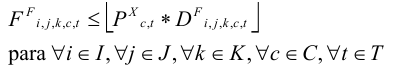

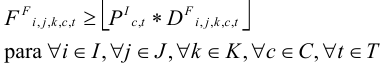

In [ ]:
# Restrições de participação máxima e mínima do armador no tipo de carga
count_constr = 0
for p in dados.P:
    for j in dados.P:
        for k in dados.K:
            for c in dados.C:
                for t in dados.T:
                    if j < p:
                        # Demanda apenas para frente
                        model.addConstr(
                            FF[p, j, k, c, t] == 0,
                            name=f"participacao_maxima_armador_{p}_{j}_{k}_{c}_{t}"
                        )

### Limite de demanda saindo de i para j em cada período t, índice do porto

In [44]:
for k in dados.K:
    for c in dados.C:
        for t in dados.T:
            for i_ in port_nums:
                for j_ in port_nums:
                    model.addConstr(FF_port[i_,j_,k,c,t] == quicksum([FF[i,j,k,c,t] for i in dados.P for j in dados.P if (ordem.loc[i].values[0] == i_ and ordem.loc[j].values[0] == j_)]),
                                    name=f'participacao_maxima_armador_{i_}_{j_}_{k}_{c}_{t} com índice do porto')
            

In [ ]:
# Restrições de participação máxima e mínima do armador no tipo de carga
count_constr = 0
for p in port_nums:
    for j in port_nums:
        for k in dados.K:
            for c in dados.C:
                for t in dados.T:
                    if True:
                        # df_filtered = dados.DF[ordem.loc[i].values[0], ordem.loc[j].values[0], k, c, t]
                        df_filtered = dados.DF[p,j,k,c,t]
                        # px_filtered = dados.PX[(dados.PX['I'] == ordem.loc[i].values[0]) & (dados.PX['C'] == c) & (dados.PX['T'] == t)]
                        px_filtered = dados.PX[(dados.PX['I'] == p) & (dados.PX['C'] == c) & (dados.PX['T'] == t)]
                        # pi_filtered = dados.PI[(dados.PI['I'] == ordem.loc[i].values[0]) & (dados.PI['C'] == c) & (dados.PI['T'] == t)]
                        pi_filtered = dados.PI[(dados.PI['I'] == p) & (dados.PI['C'] == c) & (dados.PI['T'] == t)]
                        
                        count_constr += 1
                        df_value = df_filtered
                        px_value = px_filtered['PX'].values[0]
                        pi_value = pi_filtered['PX'].values[0]

                        # Utilizando o índice do porto, sem ajuste do ordem.loc para os dados de demanda DF
                        model.addConstr(
                            FF_port[p, j, k, c, t] <= math.floor(df_value * px_value),
                            name=f"participacao_maxima_armador_{p}_{j}_{k}_{c}_{t}"
                        )
                        model.addConstr(
                            FF_port[p, j, k, c, t] >= math.floor(df_value * pi_value),
                            name=f"participacao_minima_armador_{p}_{j}_{k}_{c}_{t}"
                        )

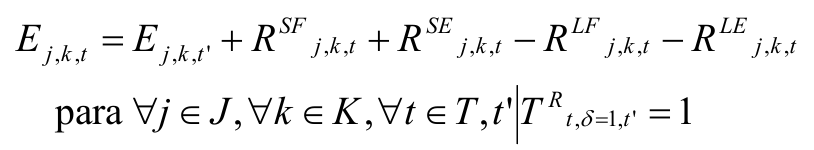

In [46]:
# Restrição de balanço de contêineres vazios nos portos
count_constr = 0
for j in dados.P:
    for k in dados.K:
        for t in dados.T:
            count_constr += 1
            model.addConstr(
                        CREMAS[j, k, t] == CREMAS[j, k, dados.T[-1] if t == 1 else t - 1] + RSE[j, k, t] + RSF[j, k, t] - RLE[j, k, t] - RLF[j, k, t],
                        name=f"balanco_conteineres_vazios_{j}_{k}_{t}"
                    )
print(f"Restrições de balanço de contêineres vazios nos portos: {count_constr}")


Restrições de balanço de contêineres vazios nos portos: 480


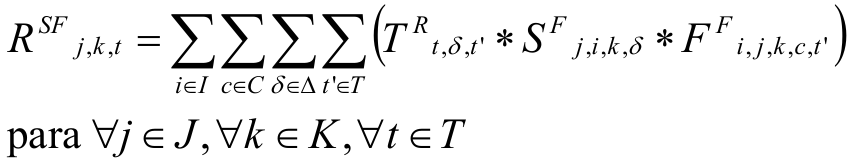

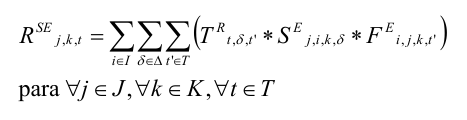

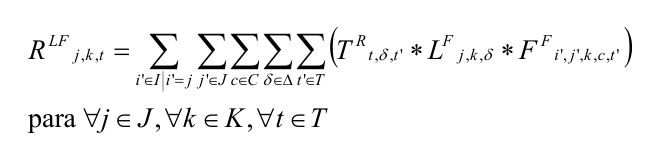

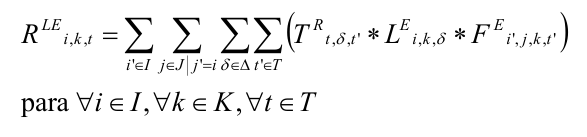

Problema: Dados.SF só tem dados para 5 portos, enquanto os outros dados chegam aos 10 portos.

Solução? Assumir que os dados para os outros portos são iguais.

In [ ]:
# Restrição de quantidade de contêineres vazios devolvida de importação
count_constr = 0
for j in dados.P:
    for k in dados.K:
        for t in dados.T:
                model.addConstr(
                    RSF[j, k, t] == quicksum([dados.TR[t, delta, t_] * FF[i, j, k, c, t_] * dados.SF[(dados.SF['I'] == ordem.loc[j].values[0]) & (dados.SF['K'] == k) & (dados.SF['DT'] == delta)]['SF'].values[0] for i in dados.P for c in dados.C for delta in dados.DT for t_ in dados.T]),
                    name=f"quantidade_conteineres_vazios_devolvida_{j}_{k}_{t}"
                )
                model.addConstr(
                    RSE[j, k, t] == quicksum([dados.TR[t, delta, t_] * FE[i, j, k, t_] * dados.SE[(dados.SE['K'] == k) & (dados.SE['DT'] == delta)]['SE'].values[0] for i in dados.P for delta in dados.DT for t_ in dados.T]),
                    name=f"quantidade_conteineres_disponiveis_pos_reposicionamento_{j}_{k}_{t}"
                )
                model.addConstr(
                RLF[j, k, t] == quicksum(
                    dados.TR[t, delta, t_] * dados.LF[(j, k, delta)] * FF[i_, j_, k, c, t_]
                    for i_ in dados.P if i_ == j
                    for j_ in dados.P
                    for c in dados.C
                    for delta in dados.DT
                    for t_ in dados.T
                ),
                name=f"restricao_RLF_{j}_{k}_{t}"
                )
                model.addConstr(
                RLE[p, k, t] == quicksum(
                    dados.TR[t, delta, t_] * dados.LF[(p, k, delta)] * FE[i_, j_, k, t_]
                    for i_ in dados.P if i_ == j
                    for j_ in dados.P
                    for c in dados.C
                    for delta in dados.DT
                    for t_ in dados.T
                ),
                name=f"restricao_RLE_{p}_{k}_{t}"
                )
                count_constr += 1
print(f"Restrições de quantidade máxima de contêineres armazenada em cada porto: {count_constr}")

Restrições de quantidade máxima de contêineres armazenada em cada porto: 480


Sf e Se considera apenas porto de chegada (índice I do Excel representa J)

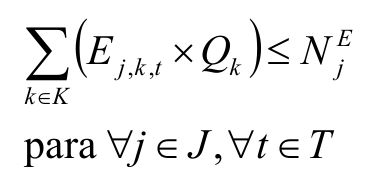

In [48]:
# Restrição de quantidade máxima de contêineres vazios em cada porto
count_constr = 0
for j in dados.P:
    for t in dados.T:
        model.addConstr(
            quicksum(CREMAS[(j, k, t)] * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] for k in dados.K) <= dados.NE[(dados.NE['I'] == ordem.loc[j].values[0])]['NE'].values[0],
            name=f"restricao_quantidade_maxima_conteineres_{j}_{t}"
        )
        count_constr += 1

print(f"Restrições de quantidade máxima de contêineres vazios em cada porto: {count_constr}")

Restrições de quantidade máxima de contêineres vazios em cada porto: 120


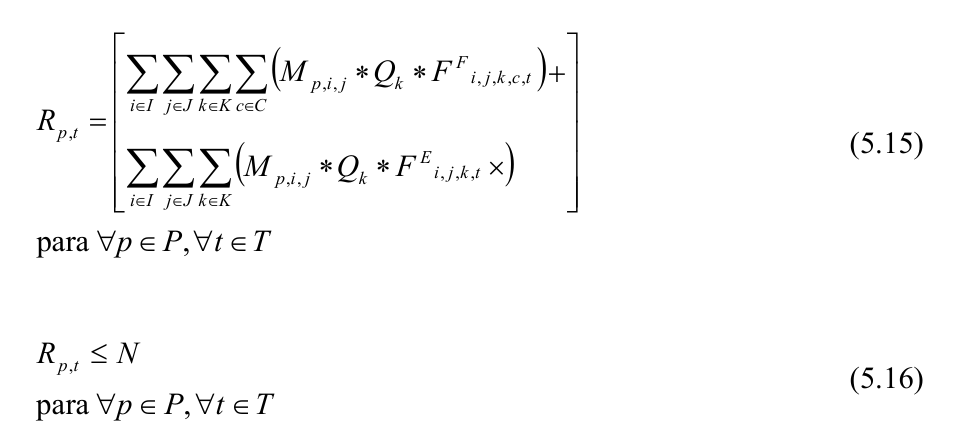

In [49]:
# Restrição (5.15) para calcular Rp,t
count_constr = 0
for p in dados.P:
    for t in dados.T:
        model.addConstr(
            R[p, t] == quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] 
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            ) + quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            ),
            name=f"calculo_R_{p}_{t}"
        )
        count_constr += 1

# Restrição (5.16) para limitar Rp,t a N
for p in dados.P:
    for t in dados.T:
        model.addConstr(
            R[p, t] <= dados.N,
            name=f"limite_R_{p}_{t}"
        )
        count_constr += 1

print(f"Restrições adicionadas: {count_constr}")


Restrições adicionadas: 240


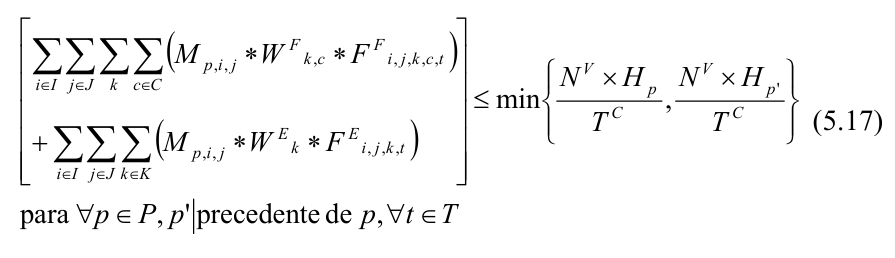

In [50]:
# Restrição de calado máximo nos portos - função de deadweight
count_constr = 0
index = -1
for p in dados.P:
    index += 1
    p_ = dados.P[index - 1]
    h = dados.H[dados.H['P'] == p]['H'].values[0]
    h_ = dados.H[dados.H['P'] == p_]['H'].values[0]
    h_value = min(h, h_)
    for t in dados.T:
        count_constr += 1
        model.addConstr(
            quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            )
            +
            quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            )
            <=
            h_value * dados.NV / dados.TC,
            name=f"calado_maximo_porto_{p}_{t}"
            )
        
        # Limite de Deadweight no navio
        model.addConstr(
            quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            )
            +
            quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            )
            <=
            dados.ND * dados.NV / dados.TC,
            name=f"deadweight_maximo_navio_{p}_{t}"
            )
        
print(f"Restrições de calado máximo nos portos: {count_constr}")

Restrições de calado máximo nos portos: 120


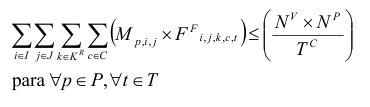

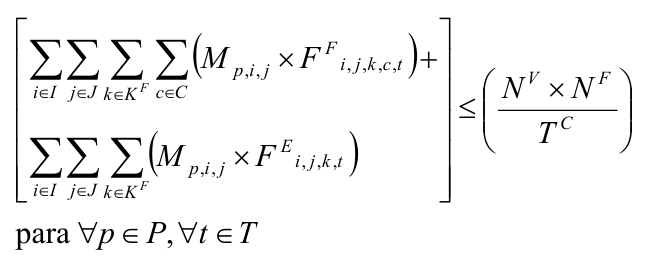

In [51]:
# Restrição de quantidade de contêineres frigoríficos cheios nos navios
count_constr = 0
for p in dados.P:
    for t in dados.T:
        count_constr += 1
        model.addConstr(
            quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * FF[i, j, k, c, t]
                for i in dados.P 
                for j in dados.P 
                for k in dados.K_Refrigerados 
                for c in dados.C) <= dados.NP * dados.NV / dados.TC,
            name=f"capacidade_maxima_refrigerados_{p}_{t}"
        )

In [52]:
# Restrição de quantidade de contêineres de 40 pés no navio
count_constr = 0
for p in dados.P:
    for t in dados.T:
        count_constr += 1

        model.addConstr(
            quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K_40pes
                for c in dados.C
            ) + quicksum(
                dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K_40pes
            ) <= (dados.NV * dados.NF / dados.TC),
            name=f"capacidade_maxima_40_pes_{p}_{t}"
        )
print(f"Restrições de quantidade de contêineres de 40 pés nos navios: {count_constr}")


Restrições de quantidade de contêineres de 40 pés nos navios: 120


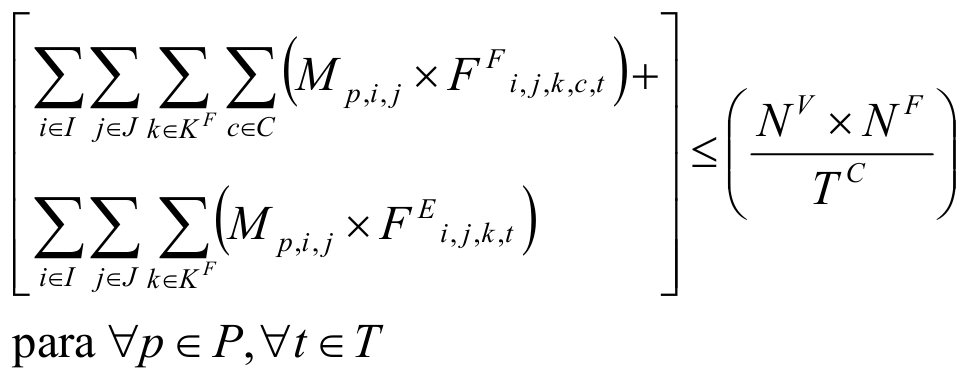

In [53]:
# Quantidade da frota utilizada vs limite

for k in dados.K:
    for t in dados.T:
        part1 = quicksum(FF[i, j, k, c, t] for i in dados.P for j in dados.P for c in dados.C)
        part2 = quicksum(FE[i, j, k, t] for i in dados.P for j in dados.P)
        part3 = quicksum(CREMAS[j, k, t] for j in dados.P)
        
        part4 = quicksum(
            dados.TR[t, delta, t_] * FF[i, j, k, c, t_] * dados.SF[(dados.SF['I'] == ordem.loc[j].values[0]) & (dados.SF['K'] == k) & (dados.SF['DT'] == delta)]['SF'].values[0] +
            dados.TR[t, delta, t_] * FE[i, j, k, t_] * dados.SE[(dados.SE['K'] == k) & (dados.SE['DT'] == delta)]['SE'].values[0]
            for i in dados.P 
            for j in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1
        )

        part5 = quicksum(
            dados.TR[t, delta, t_] * dados.LF[j1, k, delta] * FF[i, j, k, c, t_] +
            dados.TR[t, delta, t_] * dados.LE[j1, k, delta] * FE[i, j, k, t_]
            for i in dados.P
            for j in dados.P 
            for j1 in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1 and j1 == i
        )
        
        total_sum = part1 + part2 + part3 + part4 + part5
        
        model.addConstr(total_sum <= dados.NC[dados.NC['K'] == k]['NC'].values[0], name=f"lim_frota_{k}_{t}")

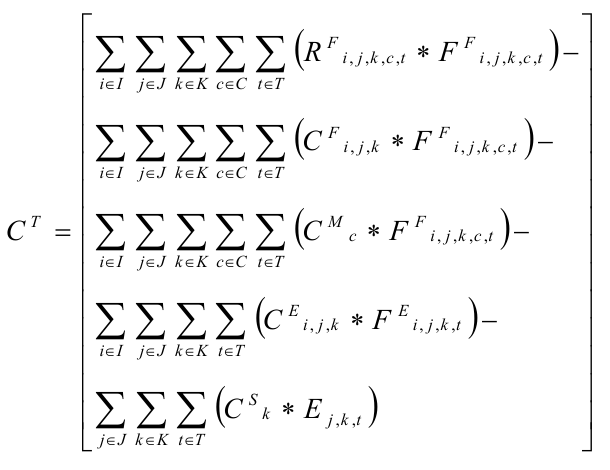

In [54]:
# Função para obter o valor de um DataFrame filtrado com valor padrão se vazio
def get_value(df, condition, column):
    filtered = df[condition]
    if not filtered.empty:
        return filtered[column].values[0]
    else:
        return 0

# Defina a função objetivo
model.setObjective(
    quicksum(
        (
            get_value(
                dados.RF, 
                (dados.RF['I'] == i) & 
                (dados.RF['J'] == j) & 
                (dados.RF['K'] == k) & 
                (dados.RF['C'] == c) & 
                (dados.RF['T'] == t), 
                'RF'
            ) * FF_port[i, j, k, c, t] -
            get_value(
                dados.CF, 
                (dados.CF['I'] == i) & 
                (dados.CF['J'] == j) & 
                (dados.CF['K'] == k), 
                'CF'
            ) * FF_port[i, j, k, c, t] -
            get_value(
                dados.CM, 
                (dados.CM['C'] == c), 
                'CM'
            ) * FF_port[i, j, k, c, t]
        )
        for i in port_nums for j in port_nums for k in dados.K for c in dados.C for t in dados.T
    ) -
    quicksum(
        get_value(
            dados.CE, 
            (dados.CE['I'] == ordem.loc[i].values[0]) & 
            (dados.CE['J'] == ordem.loc[j].values[0]) & 
            (dados.CE['K'] == k), 
            'CE'
        ) * FE[i, j, k, t]
        for i in dados.P for j in dados.P for k in dados.K for t in dados.T
    ) -
    quicksum(
        get_value(
            dados.CS, 
            (dados.CS['K'] == k), 
            'CS'
        ) * CREMAS[j, k, t]
        for j in dados.P for k in dados.K for t in dados.T
    ),
    GRB.MAXIMIZE
)

In [ ]:
# Otimizar o modelo
model.optimize()

# Verificar o status do modelo para garantir que encontrou uma solução ótima
if model.status == GRB.OPTIMAL:
    print('Solução ótima encontrada.')
    
    # Imprimir o valor da função objetivo
    print('Valor da função objetivo: ', model.objVal)
    
    # Imprimir os valores das variáveis de decisão
    for v in model.getVars():
        print(f'{v.varName}: {v.x}')
else:
    print('Não foi possível encontrar uma solução ótima.')

# Adicionalmente, se você deseja acessar valores específicos de variáveis:
# Por exemplo, se quiser imprimir valores de uma variável específica como FF[i, j, k, c, t]
for p in dados.P:
    for j in dados.P:
        for k in dados.K:
            for c in dados.C:
                for t in dados.T:
                    if FF[p, j, k, c, t].x > 0:  # Apenas imprime valores diferentes de zero
                        print(f'FF[{p},{j},{k},{c},{t}] = {FF[p, j, k, c, t].x}')


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14808 rows, 19321 columns and 201840 nonzeros
Model fingerprint: 0xf6250e94
Coefficient statistics:
  Matrix range     [1e-01, 3e+01]
  Objective range  [2e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+05]
Presolve removed 12880 rows and 12457 columns
Presolve time: 0.04s
Presolved: 1928 rows, 6864 columns, 63900 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 AA' NZ     : 4.035e+04
 Factor NZ  : 1.793e+05 (roughly 4 MB of memory)
 Factor Ops : 3.476e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl    

In [93]:
for constr in model.getConstrs():
    if constr.Pi > 0:
        print(f"{constr.ConstrName}:{constr.Pi}")

participacao_maxima_armador_2_1_1_1_1:1601.2500000000002
participacao_maxima_armador_2_1_1_1_2:1601.25
participacao_maxima_armador_2_1_1_1_3:1601.25
participacao_maxima_armador_2_1_1_1_4:1601.25
participacao_maxima_armador_2_1_1_1_5:1601.2499999999998
participacao_maxima_armador_2_1_1_1_6:1601.2499999999936
participacao_maxima_armador_2_1_1_1_7:1601.2499999999914
participacao_maxima_armador_2_1_1_1_8:1601.25
participacao_maxima_armador_2_1_1_1_9:1601.2500000000005
participacao_maxima_armador_2_1_1_1_10:1601.2500000000007
participacao_maxima_armador_2_1_1_1_11:1601.2500000000014
participacao_maxima_armador_2_1_1_1_12:1601.2500000000005
participacao_maxima_armador_2_1_2_2_1:1601.2500001393842
participacao_maxima_armador_2_1_2_2_2:1601.2499987455508
participacao_maxima_armador_2_1_2_2_3:1601.2500112900595
participacao_maxima_armador_2_1_2_2_4:1601.2498983894739
participacao_maxima_armador_2_1_2_2_5:1601.2509144947421
participacao_maxima_armador_2_1_2_2_6:1601.241769547326
participacao_max

In [ ]:
portos_repetidos = ordem[ordem.duplicated(keep=False)]
count = 0
for index_1, porto_1 in portos_repetidos.iterrows():
    for index_2, porto_2 in portos_repetidos.iterrows():
        if index_1 < index_2 and porto_1['IdPorto'] == porto_2['IdPorto']:
            for p in dados.P:
                if p > index_2:
                    for k in dados.K:
                        for c in dados.C:
                            for t in dados.T:
                                if FF[index_1, p, k, c, t].x > 0:
                                    count += 1
                                    print(f"Antecipação detectada: Embarque do porto {index_1} (porto {porto_1['IdPorto']}) para {p} (porto {ordem.loc[p].values[0]}) no t {t}.")
print(len(FF))
print(count)

Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 2.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 4.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 5.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 6.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 7.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 8.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 6.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 7.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 1.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 5.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 8.
Antecipação detectada: Embarque do porto 2 (porto 2) para 10 (porto 1) no t 11.
Antecipação detectada: Embarque do porto 2 (porto 2

In [97]:
for constr in model.getConstrs():
    if constr.Pi > 0:
        print(f"{constr.ConstrName}:{constr.Pi}")

participacao_maxima_armador_2_1_1_1_1:1601.2500000000002
participacao_maxima_armador_2_1_1_1_2:1601.25
participacao_maxima_armador_2_1_1_1_3:1601.25
participacao_maxima_armador_2_1_1_1_4:1601.25
participacao_maxima_armador_2_1_1_1_5:1601.2499999999998
participacao_maxima_armador_2_1_1_1_6:1601.2499999999936
participacao_maxima_armador_2_1_1_1_7:1601.2499999999914
participacao_maxima_armador_2_1_1_1_8:1601.25
participacao_maxima_armador_2_1_1_1_9:1601.2500000000005
participacao_maxima_armador_2_1_1_1_10:1601.2500000000007
participacao_maxima_armador_2_1_1_1_11:1601.2500000000014
participacao_maxima_armador_2_1_1_1_12:1601.2500000000005
participacao_maxima_armador_2_1_2_2_1:1601.2500001393842
participacao_maxima_armador_2_1_2_2_2:1601.2499987455508
participacao_maxima_armador_2_1_2_2_3:1601.2500112900595
participacao_maxima_armador_2_1_2_2_4:1601.2498983894739
participacao_maxima_armador_2_1_2_2_5:1601.2509144947421
participacao_maxima_armador_2_1_2_2_6:1601.241769547326
participacao_max

In [ ]:
for p in dados.P:
    for t in dados.T:
        soma_FF = sum([FF[p, j, k, c, t].x * dados.M.loc[p, ordem.loc[p].values[0], ordem.loc[j].values[0]].values[0]
                 for j in dados.P for k in dados.K for c in dados.C])
        if soma_FF > 0:
            print(f"Soma FF(i: {p}, t: {t}): {soma_FF}")

In [ ]:

# Restrição de quantidade de contêineres de 40 pés no navio
for p in dados.P:
    t = 1

    soma_cheios = sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * FF[i, j, k, c, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K_40pes
        for c in dados.C
    ) 
    soma_vazios = sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * FE[i, j, k, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K_40pes
    )

    #Em cada trecho da rota, avaliando qual a ocupação do navio
    ocupacao = (soma_cheios + soma_vazios)/dados.NV*dados.TC
    print("Ocupação do navio no trecho", p, ":", ocupacao)

    restricao_atendida = ocupacao <= dados.NF
    print("Restrição de quantidade de contêineres de 40 pés no navio atendida:", restricao_atendida)

Ocupação do navio no trecho 1 : 1175.6493572669115
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 2 : 475.88368351026674
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 3 : 517.6722417207937
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 4 : 500.51801146224085
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 5 : 0.0
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 6 : 134.44247767650197
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 7 : 122.76
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 8 : 648.3079800796392
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 9 : 1002.

In [115]:
# Restrição de calado máximo nos portos - função de deadweight
count_constr = 0
index = -1
for p in dados.P:
    index += 1
    p_ = dados.P[index - 1]
    h = dados.H[dados.H['P'] == p]['H'].values[0]
    h_ = dados.H[dados.H['P'] == p_]['H'].values[0]
    h_value = min(h, h_)
    t = 1


    calado = sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
        * FF[i, j, k, c, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K
        for c in dados.C
    ) + sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
        * FE[i, j, k, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K
    )
    
    # Limite de Deadweight no navio
    dwt = sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
        * FF[i, j, k, c, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K
        for c in dados.C
    ) + sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
        * FE[i, j, k, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K
    )
    
    print("Limite de Deadweight no navio:", dwt/dados.NV*dados.TC)

Limite de Deadweight no navio: 33835.11551358292
Limite de Deadweight no navio: 14919.774693472762
Limite de Deadweight no navio: 17408.14330317529
Limite de Deadweight no navio: 16511.66906741018
Limite de Deadweight no navio: 0.0
Limite de Deadweight no navio: 1723.5235845792645
Limite de Deadweight no navio: 4487.075674135621
Limite de Deadweight no navio: 21611.937250459287
Limite de Deadweight no navio: 27703.94603968071
Limite de Deadweight no navio: 0.0


In [116]:
# Restrição de quantidade de contêineres de 40 pés no navio
for p in dados.P:
    t = 1

    soma_cheios = sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * FF[i, j, k, c, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K
        for c in dados.C
    ) 
    soma_vazios = sum(
        dados.M.loc[p, ordem.loc[i].values[0], ordem.loc[j].values[0]].values[0]
        * FE[i, j, k, t].x
        for i in dados.P
        for j in dados.P
        for k in dados.K
    )

    #Em cada trecho da rota, avaliando qual a ocupação do navio
    ocupacao = (soma_cheios + soma_vazios)/dados.NV*dados.TC
    print("Ocupação do navio no trecho", p, ":", ocupacao)

    restricao_atendida = ocupacao <= dados.NF
    print("Restrição de quantidade de contêineres de 40 pés no navio atendida:", restricao_atendida)

Ocupação do navio no trecho 1 : 1426.6749805940613
Restrição de quantidade de contêineres de 40 pés no navio atendida: False
Ocupação do navio no trecho 2 : 524.4145476473201
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 3 : 613.6521926709696
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 4 : 602.7666776744855
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 5 : 0.0
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 6 : 161.60788384991955
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 7 : 171.60439137854016
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho 8 : 850.508603406789
Restrição de quantidade de contêineres de 40 pés no navio atendida: True
Ocupação do navio no trecho